In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Bidirectional,Dropout
from tensorflow.keras import regularizers
import keras
import matplotlib
%matplotlib inline

Using TensorFlow backend.


In [2]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
    lst.remove(label)
    data = pd_merge_new[lst]

    data1 = pd_merge_new[[label]]
    data_scale = scaler.fit_transform(data)
    data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
    df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_new.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_data_scale1.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_new[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_data_scale1], axis=1)
    return df_merge_model

df_merge_model = label('cumulative_deaths')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index                    HR_NAME        DATE health_region  \
0      0  Peel Regional Health Unit  2020-01-25          peel   
1      1  Peel Regional Health Unit  2020-01-26          peel   
2      2  Peel Regional Health Unit  2020-01-27          peel   
3      3  Peel Regional Health Unit  2020-01-28          peel   
4      4  Peel Regional Health Unit  2020-01-29          peel   

   Perceived_health_poor  Perceived_health_good PRUID_x report_date HR_UID  \
0                  0.106                  0.577      35  2020-01-25   3553   
1                  0.106                  0.577      35  2020-01-26   3553   
2                  0.106                  0.577      35  2020-01-27   3553   
3                  0.106                  0.577      35  2020-01-28   3553   
4                  0.106                  0.577      35  2020-01-29   3553   

      PROV  ...     Mr_MP      M_MP  cases  cumulative_cases  deaths  \
0  Ontario  ...  0.192156  0.621375    0.0               0.0     0.0   
1  Ontario  ...  0.193353  0.433864    0.0               0.0     0.0   
2  Ontario  ...  0.194550  0.511814    0.0               0.0     0.0   
3  Ontario  ...  0.195747  0.550314    0.0               0.0     0.0   
4  Ontario  ...  0.196944  0.568802    0.0               0.0     0.0   

   Population_density  ambulatory  hospitals  nursing_residential  \
0            0.255652         1.0   0.714286                  1.0   
1            0.255652         1.0   0.714286                  1.0   
2            0.255652         1.0   0.714286                  1.0   
3            0.255652         1.0   0.714286                  1.0   
4            0.255652         1.0   0.714286                  1.0   

   cumulative_deaths  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 52 columns]

In [3]:
## Run
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID', 'report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new

def shift_label(label, ahead_date):
#     s.rolling(5).mean().to_frame().dropna()
    col_name = str('la-'+label)
    df_new2.sort_values(by=['HR_UID'], inplace=True)
    df_new3 = df_new2.groupby(['HR_UID'])[label].rolling(5).mean().reset_index()
    df_new3.rename(columns={"cumulative_deaths": "avg5_cum_death"}, inplace=True)
#     df_new4 = df_new3.loc[df_new3['HR_UID']==str(3547)]
#     df_new3.sort_values(by=['HR_UID'], inplace=True)
    return df_new3

df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
# remove null row
df_new1.dropna(inplace=True)
# drop duplicated columns
df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]
df_new3 = shift_label('cumulative_deaths',5)
# remove null row
# df_new3.dropna(inplace=True)
df_new3.drop(['level_1'], axis=1, inplace=True)
# drop duplicated columns
df_new2.sort_values(by=['HR_UID','report_date'], inplace=True)
df_new2.reset_index(inplace=True)
df_new3.reset_index(inplace=True)
# df_new3.sort_values(by=['HR_UID'], inplace=True)
df_new4 = pd.concat([df_new2, df_new3], axis=1)
df_new4 = df_new4.loc[:,~df_new4.columns.duplicated()]
df_new4.dropna(inplace=True)
# df_new4.drop_duplicates(subset=['HR_UID','report_date'], inplace=True)
# df_merge_model.drop_duplicates(subset=['HR_UID','report_date'], inplace=True)
# print(df_merge_model.columns.tolist())
# print(df_new4.columns.tolist())
# print(df_new4.shape)
# print(df_new4.shape)
df_merge_model_new = df_merge_model[['HR_UID','report_date','Perceived_health_poor','Perceived_health_good',
               'Population_density', 'ambulatory', 'hospitals', 'nursing_residential']]
# df_merge_model_new.sort_values(by=['HR_UID','report_date'], inplace=True)
## Merge df back with health indicator
df_new5 = pd.merge(df_merge_model_new, df_new4, how = 'right', on=['HR_UID','report_date'])
# df_new5 = pd.concat([df_merge_model_new, df_new4], axis=1)
# print(df_new5.shape)
# print(df_new5.shape)
# df_new5 = pd.merge(df_merge_model_new, df_new4, how='right', on=['HR_UID','report_date'])
# remove null row
df_new5.dropna(inplace=True)
# drop duplicated columns
df_new6 = df_new5.loc[:,~df_new5.columns.duplicated()]
# df_new6.drop_duplicates(subset=['HR_UID','report_date'], inplace=True)
# print(df_new6.isnull().sum())
# print(df_new6.shape)
# # df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]
df_dum_HR = pd.get_dummies(df_new6.HR_UID, prefix='HR_UID')
df_hr_dum = pd.concat([df_new6, df_dum_HR], axis=1)

# select one hr
def df_filter(hr, case, lag_date):
    df_hr = df_hr_dum.loc[df_hr_dum['HR_UID']==str(hr)]
    df_train = df_hr.loc[(df_hr['report_date'] >= df_hr['report_date'].min()) & (df_hr['report_date'] < '2020-07-01')]
    df_eval = df_hr.loc[(df_hr['report_date'] >= '2020-07-01') & (df_hr['report_date'] <= df_hr['report_date'].max())]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    col_lst+=df_dum_HR.columns.tolist()
    
    if case:
        col_lst.append('cases')
        
#     print(df_train.columns.tolist())
    # train set
    df_feature_train = df_train[col_lst]
    df_label_train = df_train[['avg5_cum_death']]
    # eval set
    df_feature_val = df_eval[col_lst]
    df_label_val = df_eval[['avg5_cum_death']]
    # drop duplicated columns
    df_hr1 = df_hr.loc[:,~df_hr.columns.duplicated()]
   
    return df_feature_train, df_label_train, df_feature_val, df_label_val, df_hr1



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(22042, 57)


In [9]:
## Run
# split_sequences to change the dimensions of input
X_train_lst= []
X_test_lst = []
y_train_lst = []
y_test_lst = []
X_val_lst = []
y_val_lst = []

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, label_seq):
    label_seq = label_seq.reshape(label_seq.shape[0], -1)
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], label_seq[end_ix-1, :]
#         seq_x = sequences[i:end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y).reshape(-1)

for hr in df_hr_dum['HR_UID'].unique().tolist():
#     print(hr)
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
#     print(df_hr1['report_date'].tolist())
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
#     print(hr)
#     print(X_train.shape)
#     print(X_test.shape)
#     print(y_train.shape)
#     print(y_test.shape)
#     X_train, X_test, y_train, y_test = train_test_split(
#                          feature_train, label_train, test_size=0.2, random_state=42, shuffle=False)
    
    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
#     print(X_test_3d.shape)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)
    # X_train shape (124, 101)
    # val data
#     Y_val = label_val.to_numpy().reshape(-1,)
#     X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 2, Y_val)
#     X_val_lst.append(X_val_3d)
#     y_val_lst.append(y_val)
    
    
X_train = np.concatenate(X_train_lst, axis=0)
# X_train.shape (4182, 2, 101)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
# Y_train.shape (4182,)
y_test = np.concatenate(y_test_lst, axis=0)

# X_val = np.concatenate(X_val_lst, axis=0)
# y_val = np.concatenate(y_val_lst, axis=0)

Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
# Y_val = y_val.reshape(-1,)
Y_train.shape

(16321,)

In [10]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(16321, 1, 157)

In [14]:
def lstm(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features)))
    model.add(Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.08)))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [15]:
def lstm_2layer(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(30, activation='relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.08)))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [16]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 16321 samples, validate on 5721 samples
Epoch 1/50
 - 8s - loss: 0.0977 - mse: 0.0048 - mae: 0.0186 - val_loss: 0.0664 - val_mse: 4.0872e-04 - val_mae: 0.0119
Epoch 2/50
 - 7s - loss: 0.0519 - mse: 0.0037 - mae: 0.0149 - val_loss: 0.0338 - val_mse: 3.4078e-04 - val_mae: 0.0080
Epoch 3/50
 - 6s - loss: 0.0272 - mse: 0.0034 - mae: 0.0139 - val_loss: 0.0167 - val_mse: 5.0681e-04 - val_mae: 0.0146
Epoch 4/50
 - 8s - loss: 0.0144 - mse: 0.0032 - mae: 0.0134 - val_loss: 0.0077 - val_mse: 3.5866e-04 - val_mae: 0.0086
Epoch 5/50
 - 7s - loss: 0.0082 - mse: 0.0032 - mae: 0.0132 - val_loss: 0.0039 - val_mse: 4.3582e-04 - val_mae: 0.0109
Epoch 6/50
 - 10s - loss: 0.0054 - mse: 0.0028 - mae: 0.0122 - val_loss: 0.0022 - val_mse: 3.6674e-04 - val_mae: 0.0069
Epoch 7/50
 - 10s - loss: 0.0041 - mse: 0.0026 - mae: 0.0116 - val_loss: 0.0018 - val_mse: 4.0186e-04 - val_mae: 0.0067
Epoch 8/50
 - 8s - loss: 0.0035 - mse: 0.0023 - mae: 0.0104 - val_loss: 0.0016 - val_mse: 4.0239e-04 - val_mae: 0.00

In [23]:
import keras
model_90.save("reg_model/mdel90_1d_reg_5avg")
model_80.save("reg_model/mdel80_1d_reg_5avg")
model_60.save("reg_model/mdel60_1d_reg_5avg")
model_90_2.save("reg_model/mdel902_1d_reg_5avg")
model_80_2.save("reg_model/mdel802_1d_reg_5avg")
model_60_2.save("reg_model/mdel602_1d_reg_5avg")

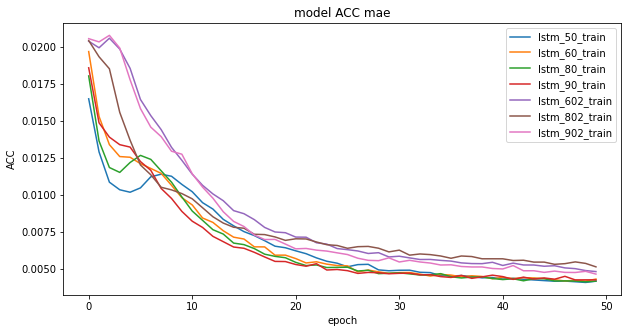

In [17]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_50.history['mae'])
plt.plot(history_60.history['mae'])
plt.plot(history_80.history['mae'])
plt.plot(history_90.history['mae'])
plt.plot(history_60_2.history['mae'])
plt.plot(history_80_2.history['mae'])
plt.plot(history_90_2.history['mae'])


# plt.plot(history_80.history['mae'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train', 'lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

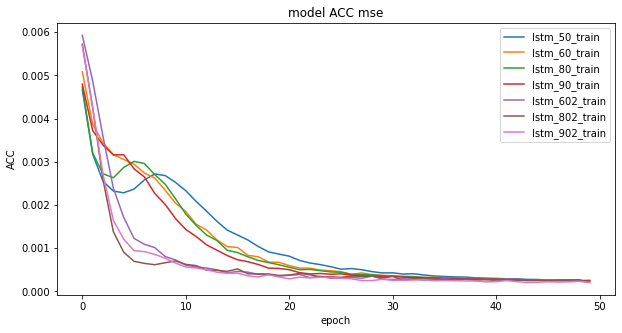

In [18]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_50.history['mse'])
plt.plot(history_60.history['mse'])
plt.plot(history_80.history['mse'])
plt.plot(history_90.history['mse'])
plt.plot(history_60_2.history['mse'])
plt.plot(history_80_2.history['mse'])
plt.plot(history_90_2.history['mse'])

plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train',
           'lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_train_lag.png')
plt.show()

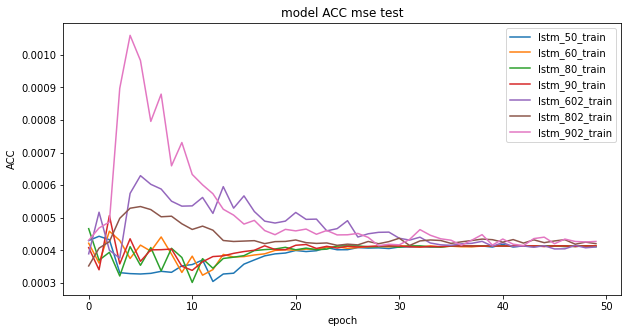

In [19]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))

plt.plot(history_50.history['val_mse'])
plt.plot(history_60.history['val_mse'])
plt.plot(history_80.history['val_mse'])
plt.plot(history_90.history['val_mse'])
plt.plot(history_60_2.history['val_mse'])
plt.plot(history_80_2.history['val_mse'])
plt.plot(history_90_2.history['val_mse'])


plt.title('model ACC mse test')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train','lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_test_lag.png')
plt.show()

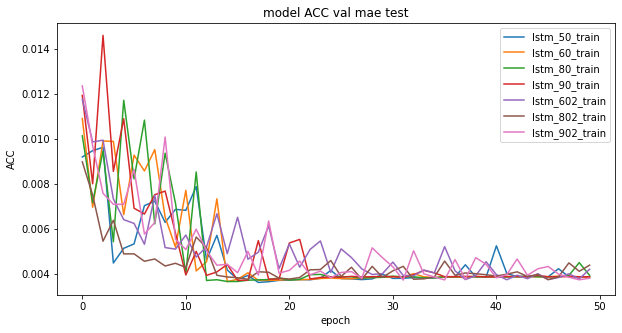

In [20]:
plt.figure(figsize=(10, 5))

plt.plot(history_50.history['val_mae'])
plt.plot(history_60.history['val_mae'])
plt.plot(history_80.history['val_mae'])
plt.plot(history_90.history['val_mae'])
plt.plot(history_60_2.history['val_mae'])
plt.plot(history_80_2.history['val_mae'])
plt.plot(history_90_2.history['val_mae'])


plt.title('model ACC val mae test')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train','lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_test_lag.png')
plt.show()

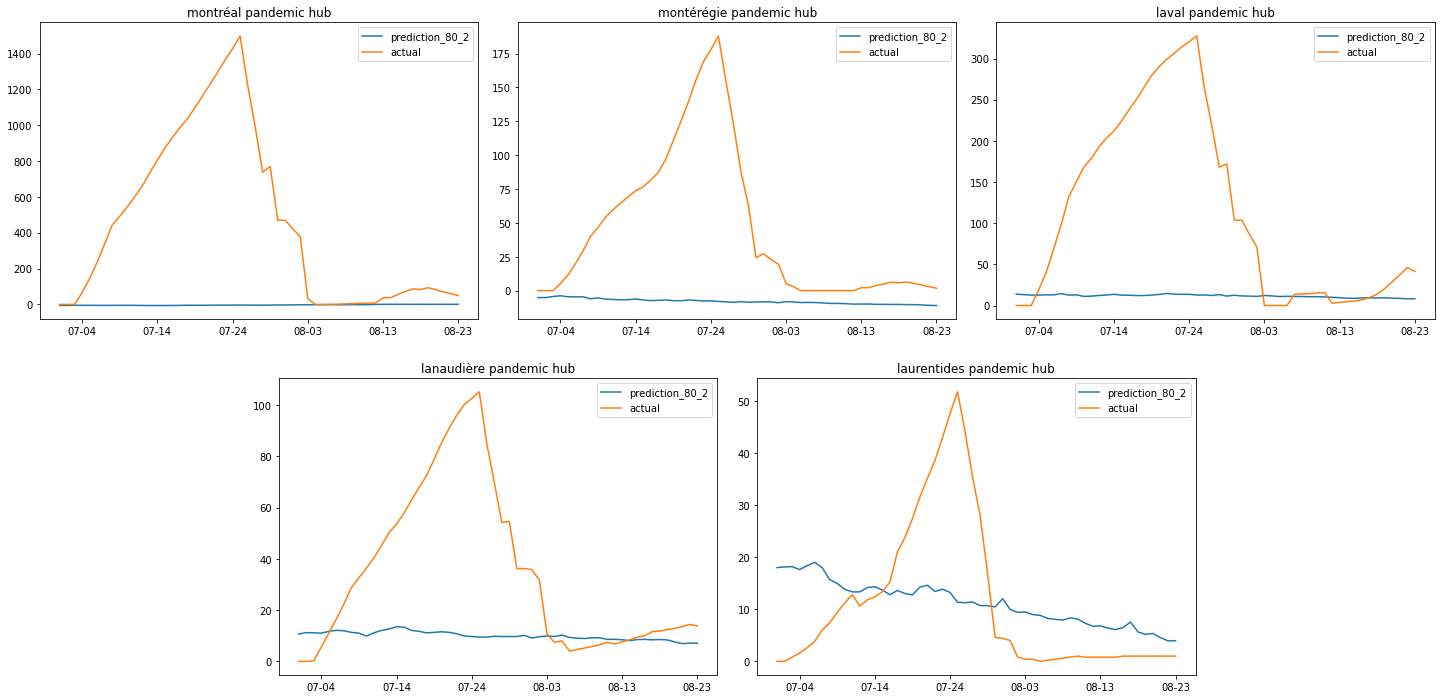

In [24]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_60_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('2406')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('montréal pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2416')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('montérégie pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2413')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('laval pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2414')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('lanaudière pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2415')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('laurentides pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
plt.savefig('Reg_AVG5/QC_5day.png')
    
    

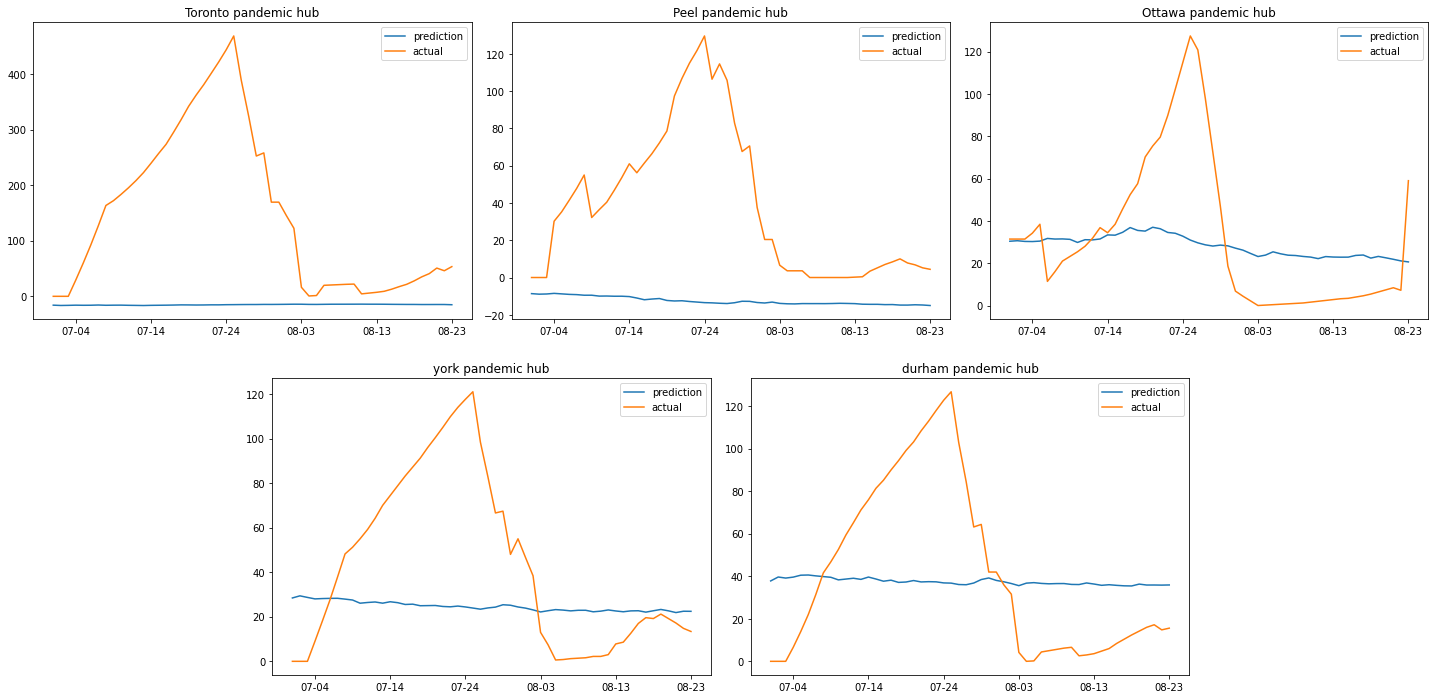

In [27]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_60_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('3595')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Toronto pandemic hub')
plt.legend(['prediction', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3553')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Peel pandemic hub')
plt.legend(['prediction', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3551')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Ottawa pandemic hub')
plt.legend(['prediction', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3570')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('york pandemic hub')
plt.legend(['prediction', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3530')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('durham pandemic hub')
plt.legend(['prediction', 'actual'])
plt.savefig('Reg_AVG5/ON_5day.png')
# plt.savefig('photo/Reg_plot/mdl90_reg_l2_ON.png')
    
    

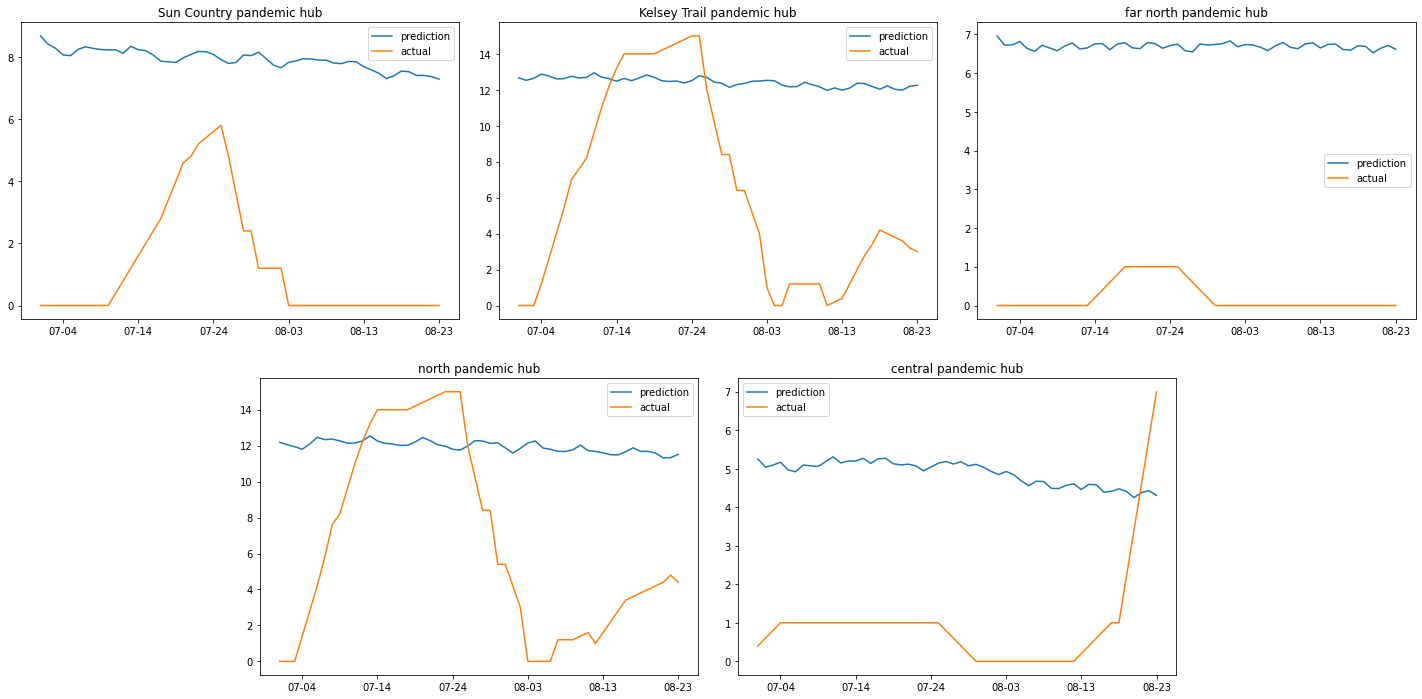

In [29]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_80_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('4701')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Sun Country pandemic hub')
plt.legend(['prediction', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4708')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Kelsey Trail pandemic hub')
plt.legend(['prediction', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4711')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('far north pandemic hub')
plt.legend(['prediction', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4709')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('north pandemic hub')
plt.legend(['prediction', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4707')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('central pandemic hub')
plt.legend(['prediction', 'actual'])
plt.savefig('Reg_AVG5/SK_5day.png')
# plt.savefig('photo/Reg_plot/mdl90_reg_l2_SK.png')
    
    

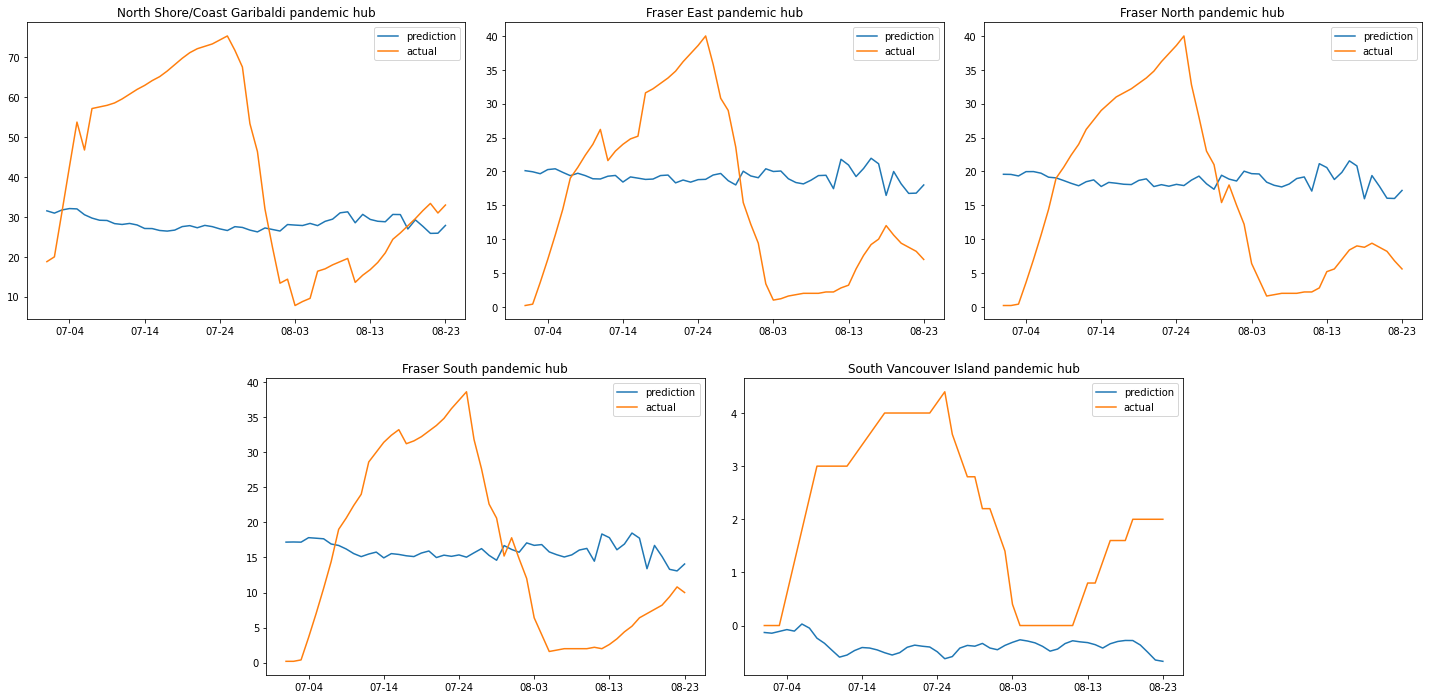

In [31]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
#     X_train, X_test, y_train, y_test = train_test_split(
#                          feature_train, label_train, test_size=0.2, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
#     x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
#     x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_90_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('5933')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('North Shore/Coast Garibaldi pandemic hub')
plt.legend(['prediction', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5921')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Fraser East pandemic hub')
plt.legend(['prediction', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5922')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Fraser North pandemic hub')
plt.legend(['prediction', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5923')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Fraser South pandemic hub')
plt.legend(['prediction', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5941')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('South Vancouver Island pandemic hub')
plt.legend(['prediction', 'actual'])
plt.savefig('Reg_AVG5/BC_5day.png')
# plt.savefig('photo/Reg_plot/mdl90_reg_l2_BC.png')
    
    